<a href="https://colab.research.google.com/github/oyjuffer/DL-Final/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# File loading

Use this when loading files from Drive on Colab, otherwise skip this cell

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# dataset directory.
data_dir= "/content/drive/MyDrive/FER-2013/"

Use this when loading the files downloaded using kaggleDownload.ipynb, otherwise skip this cell

In [3]:
data_dir= "emotion-detection-fer/"

# Data loading
Load train and validation sets.Images are resized to 96x96 pixels, as this is the smallest size available for the MobileNetV2 model. Even though the images are grayscale, they are loaded as RGB as mobilenet requires 3 channels.

In [4]:
image_size = 96 # Images are 48, but smallest model is 96
batch_size = 60

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir + "train/",
  image_size=(image_size, image_size),
  batch_size=batch_size,
  color_mode='rgb')

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir + "test/",
  image_size=(image_size, image_size),
  batch_size=batch_size,
  color_mode='rgb')

NotFoundError: Could not find directory emotion-detection-fer/train/

### List the different classes

In [33]:
class_names = val_ds.class_names
print(class_names)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


### Data preview

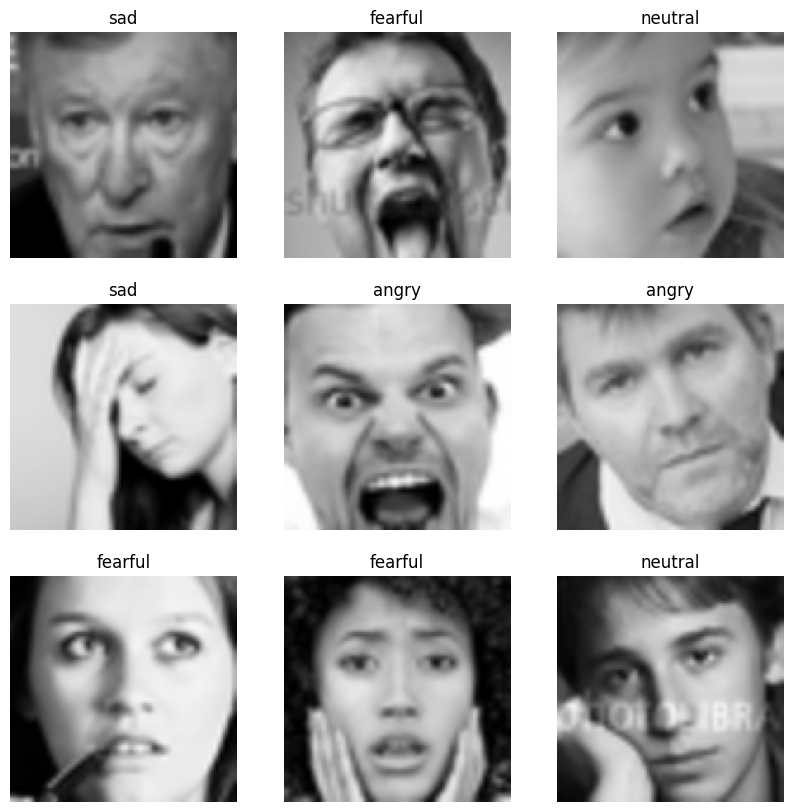

In [34]:
# Optional, just to get an understanding of whats happening
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Transfer Learning CNN model
All information on the steps is adapted from here: https://www.tensorflow.org/tutorials/images/transfer_learning

### Preprocess input
This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.

In [36]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

You will create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes.

The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [37]:
IMG_SHAPE = (image_size, image_size, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each 96x96x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:

In [ ]:
# Optional, just to get an understanding of whats happening
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(60, 3, 3, 1280)


# Feature extraction

Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [38]:
base_model.trainable = False

Important note about BatchNormalization layers

Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the Transfer learning guide.

## Show model architecture

In [39]:
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 32)   864         ['input_5[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 32)   0           ['bn_Conv1[0][0]']               
                                                                                

## Add classification head
To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [40]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(60, 1280)


## Add dense layer
Converts the features into a prediction for each image. 

In [41]:
num_classes = len(class_names)
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(60, 7)


### Build model
Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [42]:
inputs = tf.keras.Input(shape=(image_size, image_size, 3))
x = inputs
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile model

In [43]:
base_learning_rate = 0.0001

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

### Show model architecture again

In [44]:
# Optional, just to get an understanding of whats happening
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 96, 96, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 96, 96, 3)        0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

# Train the model

In [45]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
479/479 [==============================] - 130s 265ms/step - loss: 2.0291 - accuracy: 0.2458 - val_loss: 1.6813 - val_accuracy: 0.3504
Epoch 2/10
479/479 [==============================] - 122s 254ms/step - loss: 1.7510 - accuracy: 0.3375 - val_loss: 1.5745 - val_accuracy: 0.3950
Epoch 3/10
479/479 [==============================] - 118s 246ms/step - loss: 1.6529 - accuracy: 0.3738 - val_loss: 1.5224 - val_accuracy: 0.4150
Epoch 4/10
479/479 [==============================] - 112s 233ms/step - loss: 1.6027 - accuracy: 0.3875 - val_loss: 1.4874 - val_accuracy: 0.4288
Epoch 5/10
479/479 [==============================] - 118s 246ms/step - loss: 1.5571 - accuracy: 0.4081 - val_loss: 1.4630 - val_accuracy: 0.4409
Epoch 6/10
479/479 [==============================] - 117s 245ms/step - loss: 1.5221 - accuracy: 0.4248 - val_loss: 1.4453 - val_accuracy: 0.4482
Epoch 7/10
479/479 [==============================] - 120s 250ms/step - loss: 1.4952 - accuracy: 0.4293 - val_loss: 1.4313 -

## Learning curves

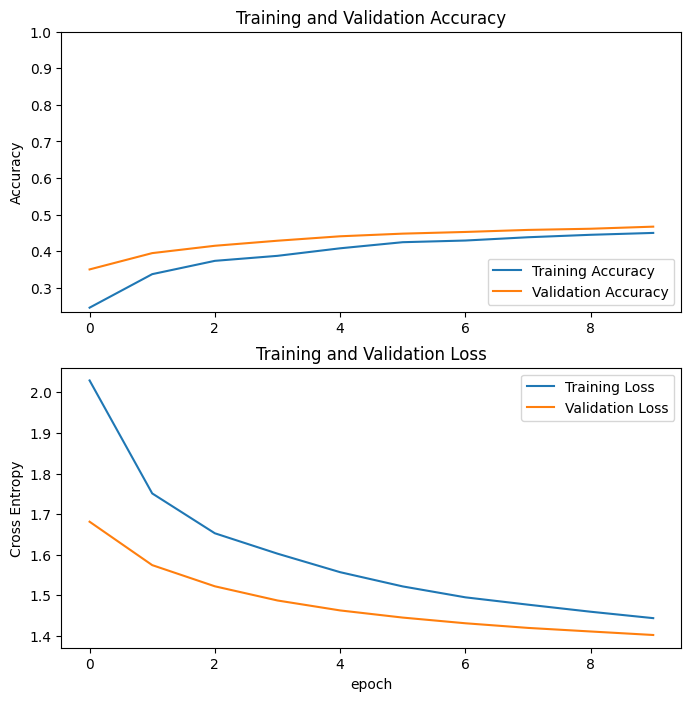

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()